In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [181]:

random.seed(0)
np.random.seed(0)
num_data = 10000
num_features = 10
x = np.random.randn(num_data, num_features)
weights = np.random.randn(num_features)
bias = 5.0
# w = np.zeros(num_features)
# b = np.zeros(1)
y = x @ weights + bias + np.random.randn(num_data) * 0.0 + (x.sum(1) > 0) * .5 + \
    (x[:,2] > .2) * 13.5 + (x[:,1] * x[:,2]) * 5.0
y = (y - y.mean())/ (y.std())

In [182]:
# ## **** Alternative (XOR) dataset
# num_data = 100
# num_features = 2
# x = np.random.randint(2, size=(num_data, num_features))
# y = (x.sum(1) % 2 == 1).astype(float) + np.random.randn(num_data)/10
# x = x + np.random.randn(num_data, num_features)/10
# df = pd.DataFrame(x)
# df['z'] = y
# import plotly.express as px
# fig = px.scatter_3d(df, x=0, y=1, z='z')
# fig.show()

In [183]:
## ****  This was our V1 linear regression model
# losses = []
# for _ in range(1000):
#     yhat = x @ w + b
#     err = y - yhat
#     w = w + (err @ x) * 1e-5
#     loss = np.square(err).mean()
#     losses.append(loss)
#     b += err.sum() * 1e-5

In [184]:
# gradient = how much do you want to impact the prediction * how much does your change impact the prediction
# gradient = desired_impact_change * effectiveness_of_changing_parameter

In [185]:
# 1 - fully implement current codebase
#     - start with code cleaning, then implement momentum
#     - Lee code cleans offline, group implments momentum, nesterov momentum, minibatch sampling
# 2- ** conv in tensorflow
# 3- implement convolution and stuff like it in numpy

In [186]:
class LeakyRelu:
    def __init__(self):
        pass
    def forward(self, x):
        self.x_last = x
        ret = np.maximum(x, .3 * x)
        return ret
    def backward(self, err, *args, **kwargs):
        return err * ((self.x_last > 0) + (self.x_last < 0) * .3)

In [187]:
class DenseNp:
    def __init__(self, in_shape, out_shape, l2_reg = 1e-5, initialization = 'xavier', momentum = 0.0,
                nesterov = True):
        self.nesterov = nesterov
        self.l2_reg = l2_reg
        self.momentum = momentum
        self.w = np.random.randn(in_shape, out_shape)
        if initialization == 'xavier':
            self.w = self.w * np.sqrt(6) / np.sqrt(in_shape + out_shape)
        self.b = np.random.randn(out_shape)/out_shape
        if momentum >0:
            self.w_vel = np.zeros_like(self.w)
            self.b_vel = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x_last = x
        if self.nesterov:
            self.w = self.w + self.w_vel * self.momentum
            self.b = self.b + self.b_vel * self.momentum
        ret = x @ self.w + self.b
        return ret
    def backward(self, err, lr):
        if len(err.shape) < 2:
            err = err[:, None]
        grad_backward = err @ self.w.T
        if self.momentum == 0:
            self.w = self.w +  ((self.x_last.T @ err) - self.l2_reg * self.w) * lr
            self.b = self.b + err.sum(0) * lr
        else:
            self.w_vel = self.w_vel * self.momentum +  (
                (self.x_last.T @ err) - self.l2_reg * self.w) * (1- self.momentum) * lr
            self.b_vel = self.b_vel * self.momentum + err.sum(0) * (1- self.momentum) * lr
            if self.nesterov:
                self.w += ((self.x_last.T @ err) - self.l2_reg * self.w) * (1- self.momentum) * lr
                self.b += err.sum(0) * (1- self.momentum) * lr
            else:
                self.w += self.w_vel
                self.b += self.b_vel

        return grad_backward

In [188]:
class Model:
    def __init__(self, layer_shapes, lr = 1e-1, momentum = 0.0):
        self.lr = lr
        self.losses = []
        self.layers = []
        for in_shape, out_shape in zip(layer_shapes[:-1], layer_shapes[1:]):
            self.layers.append(DenseNp(in_shape, out_shape, momentum = momentum))
            self.layers.append(LeakyRelu())
        self.layers = self.layers[:-1]
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def loss(self, x = None, y= None, err = None):
        if err is None:
            err = self.err(x, y)
        return np.square(err).mean()
    
    def err(self, x, y):
        yhat = self.predict(x)
        return (y - yhat)
#     def backprop(grad_output):
        
        
    def train_fullbatch(self, x, y, steps, **kwargs):
        
        for step in range(steps):
            err = self.err(x, y)
            self.losses.append(self.loss(err = err))
            grad_layer = err / y.shape[0]
            for layer in self.layers[::-1]:
                grad_layer = layer.backward(grad_layer, lr = self.lr)
            
    def train_one_epoch(self, x, y, batch_size):
        data_order = np.random.choice(x.shape[0], x.shape[0], replace=False)
        num_batch = x.shape[0]//batch_size
        minibatch_losses = 0
        for batch_idx in range(num_batch):
            if batch_idx == num_batch - 1:
                sample_idxs = data_order[batch_idx * batch_size:]
            else:
                sample_idxs = data_order[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            x_sample = x[sample_idxs]
            y_sample = y[sample_idxs]
            err = self.err(x_sample, y_sample)
            minibatch_losses += self.loss(err = err)
            grad_layer = err / y_sample.shape[0]
            for layer in self.layers[::-1]:
                grad_layer = layer.backward(grad_layer, lr = self.lr)
        self.losses.append(minibatch_losses)
        
        
    def train_minibatch(self, x, y, epochs, batch_size = 64):
        for epoch in range(epochs):
            self.train_one_epoch(x, y, batch_size = batch_size)
        
    def train(self, x, y, steps, style = 'fullbatch', **kwargs):
        {'minibatch': self.train_minibatch, 'fullbatch': self.train_fullbatch}[style](x, y, steps, **kwargs)
    def viz(self, skip_first = 0):
        plt.plot(self.losses[skip_first:])

In [189]:
mdl = Model([num_features, 16, 16, 1], momentum = .9)

In [190]:
mdl.train(x, y[:,None],1000 , style = 'minibatch')

In [191]:
[np.square(layer.w).mean() for layer in mdl.layers if hasattr(layer, 'w')]

[0.235509493488442, 0.1852976205338021, 1.0412786150079154]

In [192]:
[np.square(layer.x_last).mean() for layer in mdl.layers]

[1.0201818464696755,
 2.8861608065230246,
 1.895767446480646,
 27.971203838916477,
 4.561471530670049]

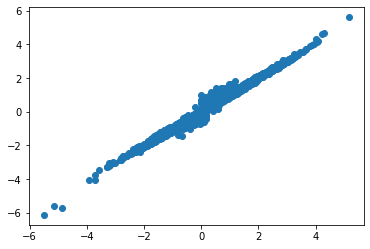

In [193]:
plt.scatter(mdl.predict(x), y)

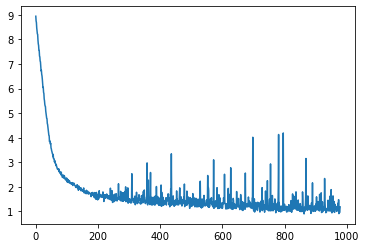

In [194]:
mdl.viz(skip_first = 20)

In [ ]:
.00001

In [201]:
x = np.arange(-12, 12, .001)
np.log(1+np.exp(x))

array([6.14419348e-06, 6.15034073e-06, 6.15649412e-06, ...,
       1.19970062e+01, 1.19980062e+01, 1.19990062e+01])

In [195]:
mdl.losses[-1]

1.183235400175535

In [196]:
from sklearn.linear_model import Ridge
baseline = Ridge().fit(x, y)
yhat = baseline.predict(x)
np.square(yhat - y).mean()

0.5648808816196393

In [197]:
mdl.loss(x, y[:,None])

0.006451065488558024